# Semi-Supervised VAE Project
## By VAEGen

## Setup

### Import libraries

In [2]:
import os
import time
import torch
import argparse
from functools import reduce
# 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Torch
import torch
from torch.distributions import Bernoulli
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

# Torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

### Meta parameters

In [3]:
batch_size=32*8*2
epochs=5
learning_rate=1e-3
latent_dim = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='cpu'
#print layers, used for debugging
NNprint_ = False
classes=[0,1,2,3,4]
num_classes=len(classes)

### Import MNIST Dataset

In [4]:
# transforms arrays into tensors, can be extended
transformations = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Lambda(lambda p: Bernoulli(probs=p).sample())])

# define the train and test sets
dset_train = MNIST(root='data', train=True,  transform=transformations, download=True)
dset_test  = MNIST(root='data', train=False, transform=transformations)

def stratified_sampler(labels,classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets,classes))
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.targets,classes))

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Plot examples

In [5]:

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
image_channels = example_data.size(1)

def plot_examples(model=None,sample=False,data=None):
    if data is None:
        if (model==None):
            batch_idx, (data, example_targets) = next(examples)
        else:
            batch_idx, (data, example_targets) = next(examples)
            if sample:
                zeros=torch.zeros(num_classes,1024)
                samples= torch.cat((torch.rand(latent_dim,1024),zeros)).T
                data = model.sample(samples.to(device))
            else:
                data = model(data.to(device),example_targets)[0]
        
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(64):
        plt.subplot(8,8,i+1)
        plt.tight_layout()
        if model:
            plt.imshow(data[i][0].cpu().data, cmap='gray', interpolation='none')
        else:
            plt.imshow(data[i][0], cmap='gray', interpolation='none')
    #     plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

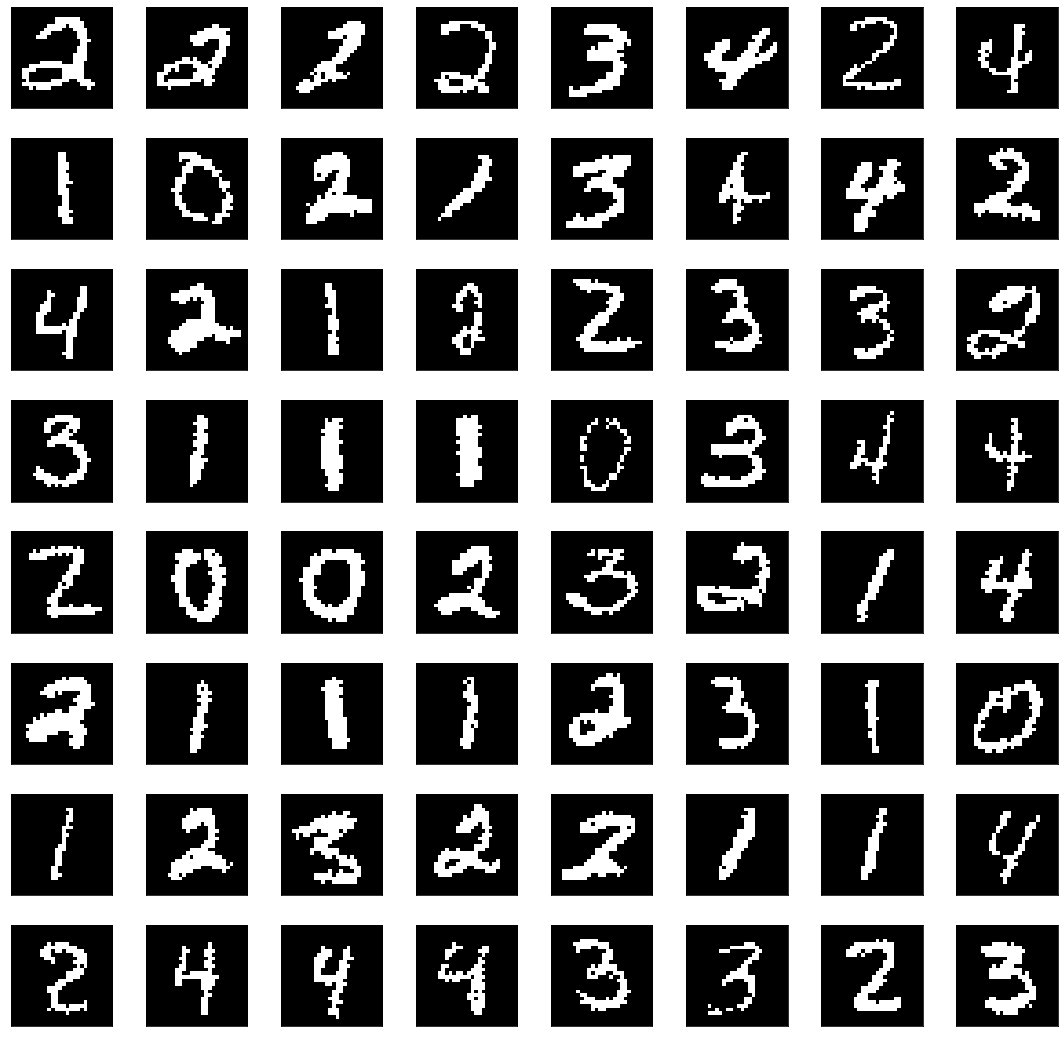

In [6]:
plot_examples()

### Torch auxiliary modules

In [7]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(torch.nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

    
class UnFlatten_FF(torch.nn.Module):
    def forward(self, input, size=784):
        return input.view(-1,1,28,28)
    
    
# Debugging module 
class NNprint(torch.nn.Module):
    def forward(self, input):
        if NNprint_==True:
            print(input.shape)
        return input  

## Feed Forward CVAE

In [8]:
# Linear CVAE
class CVAE_FF(torch.nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32, num_labels=0):
        super(CVAE_FF, self).__init__()
        self.encoder = torch.nn.Sequential(
            Flatten(),
            NNprint(),
            #torch.nn.Conv2d(image_channels, 32, kernel_size=3, stride=2),
            torch.nn.Linear(28*28,100),
            NNprint(),
            torch.nn.LeakyReLU(),
            #torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            torch.nn.Linear(100,200),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(200,400),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(400,h_dim),
            NNprint(),
            torch.nn.LeakyReLU(),
            NNprint(),
            
        )
        self.h_dim=h_dim
        self.num_labels=num_labels
        self.fc1 = torch.nn.Linear(h_dim, z_dim)
        self.fc2 = torch.nn.Linear(h_dim, z_dim)
        self.fc3 = torch.nn.Linear(z_dim+num_labels, h_dim)
        
        self.decoder = torch.nn.Sequential(
            NNprint(),
            torch.nn.Linear(h_dim,400),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.Linear(400,200),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.Linear(200,100),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.Linear(100,28*28),
            torch.nn.Sigmoid(),
            NNprint(),
            UnFlatten_FF()
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu.to(device) + std.to(device) * esp.to(device)
        return z
    
    def bottleneck(self, h,labels):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        if self.num_labels>0:
            z=torch.cat((z,torch.nn.functional.one_hot(labels,self.num_labels).type(torch.float).to(device)),1)
        return z, mu, logvar

    def encode(self, x,labels):
        h = self.encoder(x)
#         h=torch.cat((h,labels.float().reshape(labels.size(0),1).to(device)),dim=1)
        z, mu, logvar = self.bottleneck(h,labels)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    
    
    def forward(self, x,labels):
        z, mu, logvar = self.encode(x,labels)
#         print('z',z.shape)
        z = self.decode(z)
        return z, mu, logvar
    
    def elbo(self,recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x.to(device), size_average=False,reduction='sum' )
        # BCE = F.mse_loss(recon_x, x, size_average=False)

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = 0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE - KLD, BCE, KLD

    def sample(self,z):
        return self.decode(z)

## Convolutional CVAE

In [9]:

class CVAE(torch.nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32,num_labels=0):
        super(CVAE, self).__init__()
        self.encoder = torch.nn.Sequential(
            NNprint(),
            torch.nn.Conv2d(image_channels, 32, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            Flatten(),
            
            
            NNprint(),
            
        )
        self.h_dim=h_dim
        self.num_labels=num_labels
        self.fc1 = torch.nn.Linear(h_dim, z_dim)
        self.fc2 = torch.nn.Linear(h_dim, z_dim)
        self.fc3 = torch.nn.Linear(z_dim+num_labels, h_dim)
        
        self.decoder = torch.nn.Sequential(
            NNprint(),
            UnFlatten(),
            NNprint(),
            torch.nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4,padding=0, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=1),
            torch.nn.Sigmoid(),
            NNprint(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu.to(device) + std.to(device) * esp.to(device)
        return z
    
    def bottleneck(self, h,labels):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        if self.num_labels>0:
            z=torch.cat((z,torch.nn.functional.one_hot(labels,self.num_labels).type(torch.float).to(device)),1)
        return z, mu, logvar

    def encode(self, x,labels):
        h = self.encoder(x)
#         h=torch.cat((h,labels.float().reshape(labels.size(0),1).to(device)),dim=1)
        z, mu, logvar = self.bottleneck(h,labels)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    
    
    def forward(self, x,labels):
        z, mu, logvar = self.encode(x,labels)
#         print('z',z.shape)
        z = self.decode(z)
        return z, mu, logvar
    
    def elbo(self,recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x.to(device), size_average=False,reduction='sum' )
        # BCE = F.mse_loss(recon_x, x, size_average=False)

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = 0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE - KLD, BCE, KLD

    def sample(self,z):
        return self.decode(z)

# Semi-supervised Convolutional CVAE

In [24]:
class SS_CVAE_CONV(torch.nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32, num_labels=0):
        super(SS_CVAE_CONV, self).__init__()
        self.encoder = torch.nn.Sequential(
            NNprint(),
            torch.nn.Conv2d(image_channels, 32, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1),
            NNprint(),
            torch.nn.LeakyReLU(),
            Flatten(),
            NNprint(),
            
        )
        self.h_dim=h_dim
        self.num_labels=num_labels
        self.fc1 = torch.nn.Linear(h_dim + num_labels, z_dim)
        self.fc2 = torch.nn.Linear(h_dim + num_labels, z_dim)
        self.fc3 = torch.nn.Linear(z_dim+num_labels, h_dim)
        
        self.decoder = torch.nn.Sequential(
            NNprint(),
            UnFlatten(),
            NNprint(),
            torch.nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4,padding=0, stride=2),
            torch.nn.LeakyReLU(),
            NNprint(),
            torch.nn.ConvTranspose2d(32, image_channels, kernel_size=5, stride=1),
            torch.nn.Sigmoid(),
            NNprint(),
        )

        # simple FFNN classifier
        # input: flattened vector, output: probability of each class
        self.classifier = torch.nn.Sequential(
            Flatten(),
            torch.nn.Linear(784, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 10), # 3 output layer
            torch.nn.Softmax(dim=1)
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu.to(device) + std.to(device) * eps.to(device)
        return z

    def encode(self, x, y=None):
        # pass x through conv encoder and flatten output to obtain h
        h = self.encoder(x)

        # concat y (labels) to h, to place in latent space
        if y is not None:
            h = torch.cat((h, torch.nn.functional.one_hot(y, self.num_labels).type(torch.float).to(device)), 1) # TODO: Do this outside

        # fc1 encodes [h,y] into mu; fc2 encodes [h,y] into logvar
        mu, logvar = self.fc1(h), self.fc2(h)
        
        return mu, logvar

    def decode(self, z):
        # n.b. z is really [z,y]
        z = self.fc3(z) # upscale [z,y] to h_dim
        x_recon = self.decoder(z) # decode upscaled [z,y] to x_recon
        return x_recon
    
    def forward(self, x_labelled, x_unlabelled, y):
        #######################################################################
        # labeled case ########################################################
        #######################################################################
        # encode [x_labelled,y] to mu_lab and logvar_lab
        mu_lab, logvar_lab = self.encode(x_labelled, y)
        
        # sample z_lab using mu_lab and logvar_lab
        z_lab = self.reparameterize(mu_lab, logvar_lab)

        # concat y (labels) to z_lab, to place in latent space
        z_lab = torch.cat((z_lab, torch.nn.functional.one_hot(y, self.num_labels).type(torch.float).to(device)), 1) # TODO: Do this outside

        # decode [z_lab,y] to get reconstruction
        x_lab_recon = self.decode(z_lab)


        #######################################################################
        # classification ######################################################
        #######################################################################
        y_labelled_pred = self.classifier(x_labelled)


        #######################################################################
        # unlabeled case ######################################################
        #######################################################################
        # predict a y for the entropy term, H(q(y|x))
        y_unlabelled_pred = self.classifier(x_unlabelled)

        # integrate over y
        # i.e. calculate loss for any possible class of y
        # We tile x_unlabelled and y, then concat for parallelism
        # TODO: n.b. repeat coopies the data, so there might be a less expensive way to do this
        x_unlab_tiled = x_unlabelled.repeat(self.num_labels,1,1,1)

        # TODO: init y_unlab outside forward instead of here and in forward()
        # tensor of class labels [0,1,2,3,4,5,6,7,8,9], repeated for number of datapoints as [0_0,0_1,0_n, ...]
        y_unlab_tiled = torch.repeat_interleave(torch.arange(self.num_labels), x_unlabelled.shape[0])
        # y_unlab = torch.nn.functional.one_hot(y_unlab, self.num_labels).type(torch.float) # one-hot in forward()
        # x_y_unlab = torch.cat((x_unlab_tiled, y_unlab), 1) # this is done in forward

        # encode x_unlab and y_unlab to mu_unlab and logvar_unlab
        mu_unlab, logvar_unlab = self.encode(x_unlab_tiled, y_unlab_tiled)

        # sample z_unlab via mu_unlab and logvar_unlab
        z_unlab = self.reparameterize(mu_unlab, logvar_unlab)

        # concat y (labels) to z_lab, to place in latent space
        z_unlab = torch.cat((z_unlab, torch.nn.functional.one_hot(y_unlab_tiled, self.num_labels).type(torch.float).to(device)), 1) # TODO: Do this outside

        # decode [z_unlab,y_unlab] to get reconstruction
        x_unlab_recon = self.decode(z_unlab)

        # TODO: Expand on this dict to name vars properly
        return {'L' : (mu_lab, logvar_lab, z_lab, x_lab_recon), \
                'U' : (mu_unlab, logvar_unlab, z_unlab, x_unlab_recon), \
                'C' : (y, y_labelled_pred)}
    
    def J_alpha(self, L, U, C, a=.1):
      """Calculate loss as J_alpha

      J_alpha = J + alpha * C

      Where
        J = ∑L(x,y) + ∑U(x)
        -L(x,y) = E_q(z|x,y)[logp(x|y,z) + logp(y) + logp(z) - logq(z|x,y)]
        -U(x) = ∑_y q(y|x)(-L(x,y)) + H(q(y|x))
        C = E_p(x,y) [-logq(y|x)]
      
      
      """
      # n.b. this implementation is verbose for the sake of clarity
      mu, logvar = L[0], L[1]
      z = L[2]
      x_recon = L[3] # TODO: get x
      # logp(x|y,z) + logp(y) + logp(z) - logq(z|x,y)
      logpx = F.binary_cross_entropy(recon_x, x.to(device), size_average=False, reduction='sum') # TODO: sum?
      logpy = torch.log(0.1) # TODO: dont hard code
      logpz = 1 # logprob Gaussian for z, 0, I
      logqz = 1 # logprob Gaussian for z, mu, logvar
      L = torch.arange(1.0)

      U = torch.arange(1.0)

      # classification error
      y = C[0]
      y_pred = C[1]
      C = F.cross_entropy(y_pred, y, reduction='mean')
      
      J = torch.mean(L) + torch.mean(U) # mean for expectation instead of sum
      Ja = J + a * C
      return Ja
      

    def elbo(self,recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x.to(device), size_average=False, reduction='sum')
        # BCE = F.mse_loss(recon_x, x, size_average=False)

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = 0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE - KLD, BCE, KLD

    def sample(self,z):
        return self.decode(z)

# test model
model = SS_CVAE_CONV(image_channels=image_channels, h_dim=1024, z_dim=latent_dim, num_labels=num_classes).to(device)
print(model)

# test forward-pass
x_l = example_data[:52]
y_l = example_targets[:52]
x_u = example_data[52:]
out_fpass = model(x_l, x_u, y_l)

# test loss
loss = model.J_alpha(out_fpass['L'], out_fpass['U'], out_fpass['C'])
print(loss)

SS_CVAE_CONV(
  (encoder): Sequential(
    (0): NNprint()
    (1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (2): NNprint()
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): NNprint()
    (6): LeakyReLU(negative_slope=0.01)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): NNprint()
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (11): NNprint()
    (12): LeakyReLU(negative_slope=0.01)
    (13): Flatten()
    (14): NNprint()
  )
  (fc1): Linear(in_features=1029, out_features=8, bias=True)
  (fc2): Linear(in_features=1029, out_features=8, bias=True)
  (fc3): Linear(in_features=13, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): NNprint()
    (1): UnFlatten()
    (2): NNprint()
    (3): ConvTranspose2d(1024, 128, kernel_size=(4, 4), stride=(2, 2))
    (4): LeakyReLU(negative_slope=0.01)
    (5): NNprint()
    (6): ConvTranspose2

In [66]:
x_unlabelled = torch.randint(0, 1, (64, 728)) # like a batch of images

# x_unlabelled.size()
# x_unlab_tiled = x_unlabelled.unsqueeze(0)
# x_unlab_tiled = x_unlab_tiled.expand(10,64,728) # test this

# n.b. repeat coopies the data, so there might be a less expensive way to do this
# e.g. by expanding into 3rd dim??
x_unlab_tiled = x_unlabelled.repeat(10,1)

y_unlab = torch.repeat_interleave(torch.arange(10), x_unlabelled.shape[0])
y_unlab = torch.nn.functional.one_hot(y_unlab, 10).type(torch.float)

x_y_unlab = torch.cat((x_unlab_tiled, y_unlab), 1)

# print(x_unlab_tiled.shape, y_unlab.shape)





# y = torch.randint(0, 10,(1,1)).to(dtype=torch.long) # 10=number of classes
# y = torch.nn.functional.one_hot(y,10).type(torch.float).to(device,dtype=z.dtype)[0]

torch.Size([640, 728]) torch.Size([640, 10])


In [20]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randint(5, (3,), dtype=torch.int64)
print(input)
print(target)
# F.cross_entropy(input, target)

tensor([[ 1.4417,  0.8400, -1.5465, -0.6570, -0.0203],
        [-0.3153, -2.8060,  0.2333,  0.5586,  0.9705],
        [-0.2373, -0.5782, -0.8290,  0.1227,  0.7330]], requires_grad=True)
tensor([3, 2, 1])


In [ ]:
model = SS_CVAE_CONV(image_channels=image_channels,h_dim=1024,z_dim=latent_dim,num_labels=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def fit_model(model, train_loader):
    model.train()
    running_loss = 0.0
    # Run each batch in training dataset
    for idx, (images, labels) in enumerate(train_loader):
        recon_images, mu, logvar = model(images.to(device),labels)
        loss, bce, kld = model.elbo(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    return running_loss/len(train_loader.dataset)
    

def test_model(model, test_loader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            recon_images, mu, logvar = model(images.to(device),labels)
            loss, bce, kld = model.elbo(recon_images, images, mu, logvar)
            running_loss += loss

    return running_loss/len(test_loader.dataset)

In [ ]:
print(model)

CVAE_FF(
  (encoder): Sequential(
    (0): Flatten()
    (1): NNprint()
    (2): Linear(in_features=784, out_features=100, bias=True)
    (3): NNprint()
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=100, out_features=200, bias=True)
    (6): NNprint()
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=200, out_features=400, bias=True)
    (9): NNprint()
    (10): LeakyReLU(negative_slope=0.01)
    (11): Linear(in_features=400, out_features=1024, bias=True)
    (12): NNprint()
    (13): LeakyReLU(negative_slope=0.01)
    (14): NNprint()
  )
  (fc1): Linear(in_features=1024, out_features=8, bias=True)
  (fc2): Linear(in_features=1024, out_features=8, bias=True)
  (fc3): Linear(in_features=13, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): NNprint()
    (1): Linear(in_features=1024, out_features=400, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): NNprint()
    (4): Linear(in_features=400, out_features=200, bias=True)
   

In [ ]:
%%time
##
train_loss = []
test_loss = []

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit_model(model, train_loader)
    test_epoch_loss = test_model(model, test_loader)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {test_epoch_loss:.4f}")

torch.save(model.state_dict(), 'cvae.torch')


Epoch 1 of 5
Train Loss: 182.0058
Val Loss: 147.0254
Epoch 2 of 5
Train Loss: 136.6663
Val Loss: 132.9854
Epoch 3 of 5
Train Loss: 130.4136
Val Loss: 130.8115
Epoch 4 of 5
Train Loss: 127.7477
Val Loss: 127.7773
Epoch 5 of 5
Train Loss: 125.4502
Val Loss: 126.4101
CPU times: user 1min 5s, sys: 150 ms, total: 1min 5s
Wall time: 28.6 s


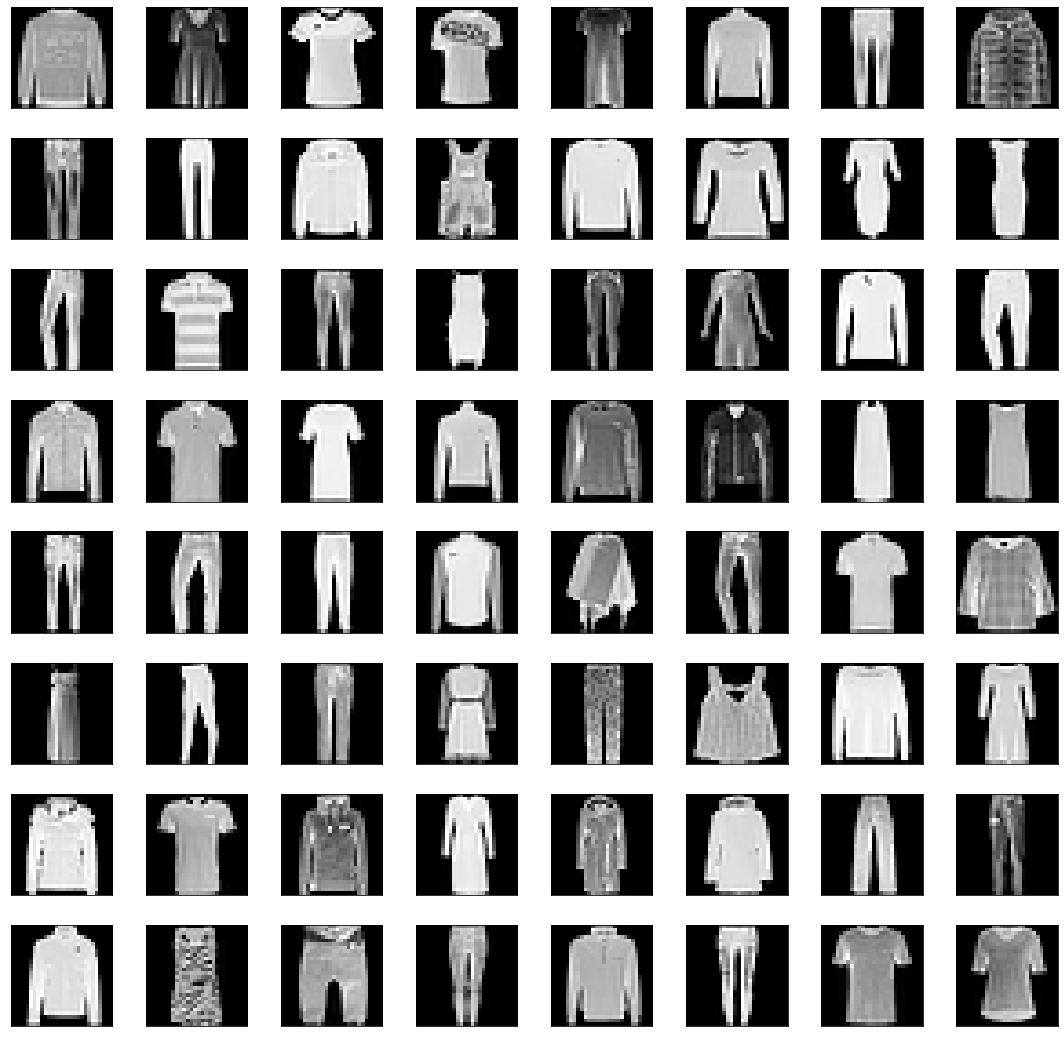

In [ ]:
plot_examples()

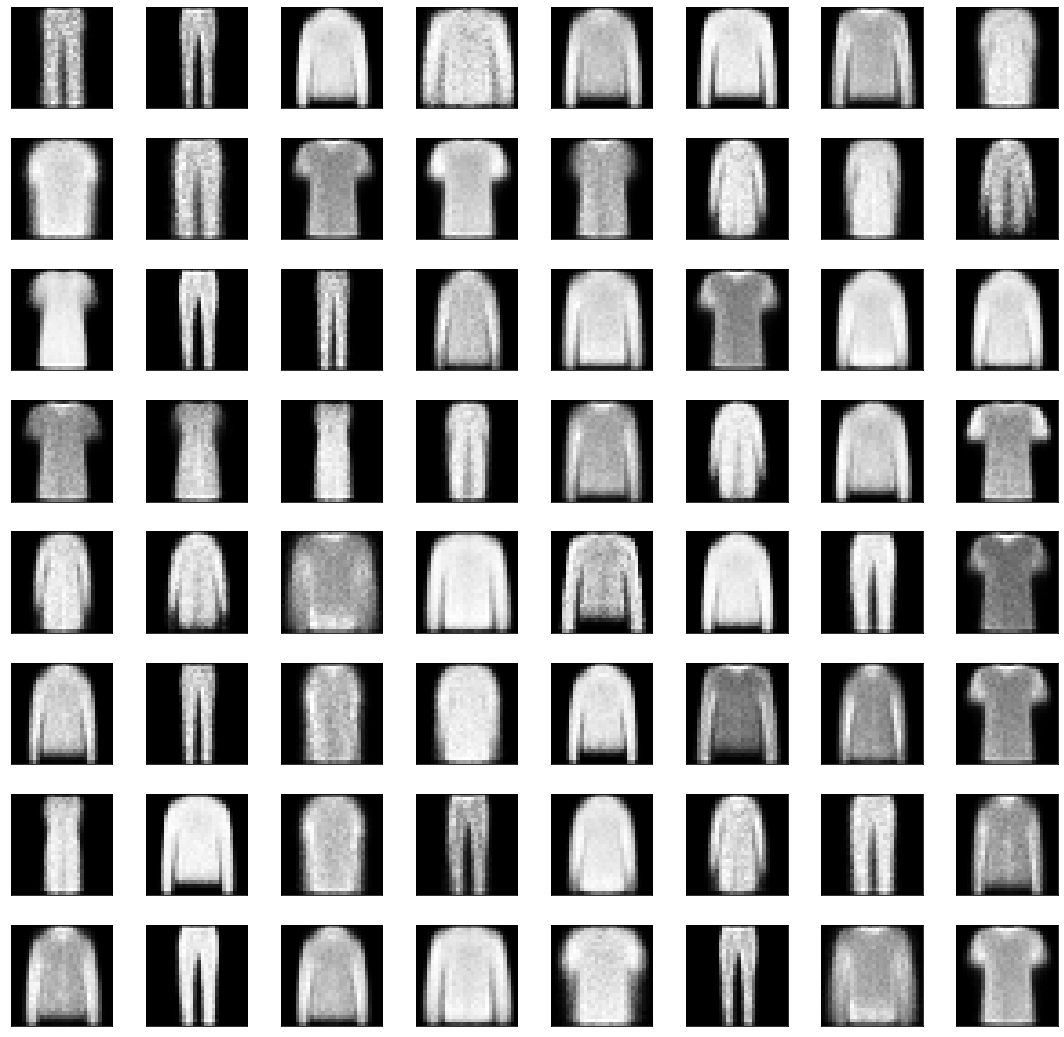

In [ ]:
#Reconstructions
plot_examples(model)


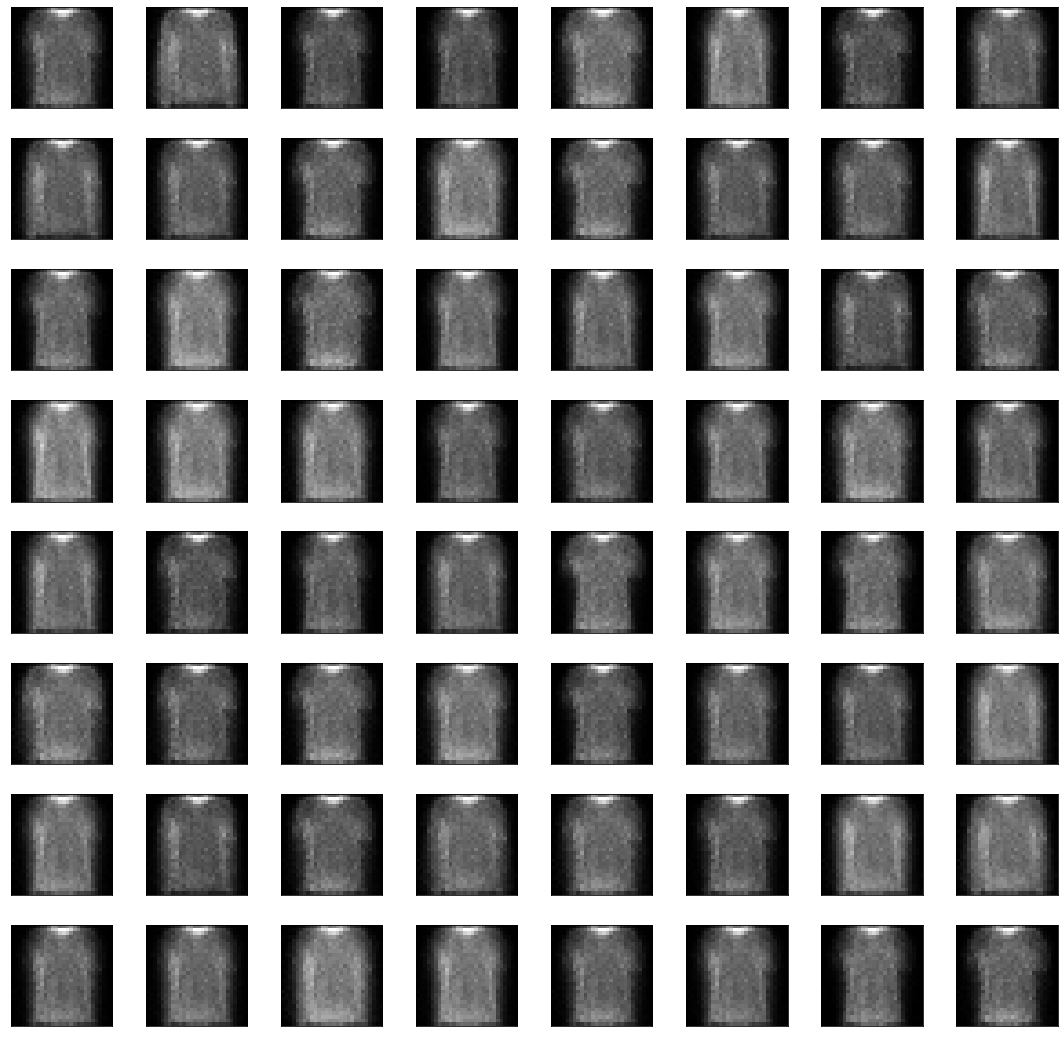

In [ ]:
# Sample latent space
plot_examples(model,sample=True)

# 2.3  Semi-Supervised VAE (M1)

We have now trained a VAE on the full unlabeled dataset.  We will now implement the M1 model from Semi-Supervised Learning with Deep Generative Models. This amounts to simply traininga classifier on top of the representations learned by our VAE.

1. Extract 100 labeled datapoints from MNIST (10 from each class).
2.(Report) Train a classifier on their latent representation.  First try a linear classifier and then experiment with other types of classifiers.  Report the accuracies.
3.(Report) Implement  some  simple  baselines:  Train  a  linear  classifier  or  neural  network  from scratch using only the 100 labeled data points.  Report the accuracies.

In [ ]:
# 0 Train VAE on all available data (X), without labels (y)

model = CVAE(image_channels=image_channels,h_dim=1024,z_dim=latent_dim,num_labels=0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
##
train_loss = []
test_loss = []
epochs=5
learning_rate=1e-3

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit_model(model, train_loader)
    test_epoch_loss = test_model(model, test_loader)
    train_loss.append(train_epoch_loss)
    test_loss.append(test_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {test_epoch_loss:.4f}")

# torch.save(model.state_dict(), 'cvae.torch')

Epoch 1 of 5


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Train Loss: 117.6458
Val Loss: 91.3892
Epoch 2 of 5
Train Loss: 80.4845
Val Loss: 64.7040
Epoch 3 of 5
Train Loss: 55.2358
Val Loss: 48.9142
Epoch 4 of 5
Train Loss: 47.4716
Val Loss: 45.3025
Epoch 5 of 5
Train Loss: 44.6698
Val Loss: 43.1558


In [ ]:
# 1 Extract 100 labeled datapoints from MNIST (10 from each class).

def get_target_indexes(dset, n_class_examples):
  idxs = []
  ts = []
  n_samples = n_class_examples * len(np.unique(dset_train.targets.numpy()))

  for j, x in enumerate(dset.targets):
    if (ts.count(x.numpy()) < n_class_examples):
      ts.append(x.numpy())
      idxs.append(j)

    if len(idxs) == n_samples:
      break

  return idxs

# np.unique(dset_train.targets[idxs].numpy(), return_counts=True)
# torch.utils.data.Subset(dset_train, idxs)

In [ ]:
idx_train_subset = get_target_indexes(dset_train, 10)
dset_train_subset = torch.utils.data.Subset(dset_train, idx_train_subset)

dset_train_subset_loader = torch.utils.data.DataLoader(
  dset_train_subset,
  batch_size=1000)

In [ ]:
idx_test_subset = get_target_indexes(dset_test, 100)
dset_test_subset = torch.utils.data.Subset(dset_test, idx_test_subset)

dset_test_subset_loader = torch.utils.data.DataLoader(
  dset_test_subset,
  batch_size=100)

In [ ]:
# 2 (Report) Train a classifier on their latent representation. 
# First try a linear classifier and then experiment with other types of classifiers. Report the accuracies.

from sklearn.linear_model import LogisticRegression

model.eval()

X_train = None

with torch.no_grad():
    for idx, (images, labels) in enumerate(dset_train_subset_loader):
        recon_images, mu, logvar = model(images.to(device), None)
        X_train = mu.numpy()

y_train = dset_train.targets[idx_train_subset]
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

print("Loss (train): ", clf.score(X_train, y_train))

Loss (train):  0.94


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
X_test = None
err = []
with torch.no_grad():
    for idx, (images, labels) in enumerate(dset_test_subset_loader):
        recon_images, mu, logvar = model(images.to(device), None)
        X_test = mu.numpy()
        y_test = labels.numpy()
        err.append(clf.score(X_test, y_test))

print("Mean loss (test): ", np.mean(np.array(err)))

[0.66, 0.59, 0.68, 0.58, 0.64, 0.62, 0.56, 0.69, 0.66, 0.54]
Mean loss (test):  0.622


In [ ]:
# 

z1 = torch.randn(1, latent_dim).to(device)
z2 = torch.randn(1, latent_dim).to(device)
z3 = torch.randn(1, latent_dim).to(device)
z4 = torch.randn(1, latent_dim).to(device)

y = torch.randint(0, 10,(1,1)).to(dtype=torch.long) # 10=number of classes
y = torch.nn.functional.one_hot(y,10).type(torch.float).to(device,dtype=z.dtype)[0]

z1 = torch.cat((z1,y),dim=1)
z2 = torch.cat((z2,y),dim=1)
z3 = torch.cat((z3,y),dim=1)
z4 = torch.cat((z4,y),dim=1)

print(z1)
print(z2)
print(z3)
print(z4)
rec1 = model.decode(z1)
rec2 = model.decode(z2)
rec3 = model.decode(z3)
rec4 = model.decode(z4)

img1 = rec1.view(28,28).data
img2 = rec2.view(28,28).data
img3 = rec3.view(28,28).data
img4 = rec4.view(28,28).data


In [ ]:
plt.figure()
plt.imshow(img1.to('cpu'), cmap='gray')

In [ ]:
plt.figure()
plt.imshow(img2.to('cpu'), cmap='gray')

In [ ]:
plt.figure()
plt.imshow(img3.to('cpu'), cmap='gray')

In [ ]:
plt.figure()
plt.imshow(img4.to('cpu'), cmap='gray')